<a href="https://colab.research.google.com/github/soobook/TensorFlow-DL/blob/main/code/TF14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14회차: RNN을 활용한 항공 여행자 수 예측 (4) - 모델 최적화

## RNN 구현

In [1]:
# 시각화 준비
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.7 MB/s eta 0:00:00


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. 데이터 로드 및 전처리
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

### 정규화 (Normalization)의 적용
- 로그 변환 후 MinMax 정규화
- 로그 변환 효과
  - 지수적으로 증가하던 데이터를 직선처럼 보이게 만들어 줌
  - 분산을 줄여서 학습 안정성 확보
  - 시계열 데이터의 과도한 성장과 변동성을 누그러뜨리는 효과
- 분포를 먼저 안정화시킨 후, MinMaxScaler로 0~1 범위로 맞추는 방법

In [3]:
# 로그 변환 + 정규화
df['Passengers_log'] = np.log(df['Passengers'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Passengers_log']])

In [4]:
df

,Passengers,Passengers_log
Month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791
...,...,...
1960-08-01,606,6.406880
1960-09-01,508,6.230481
1960-10-01,461,6.133398


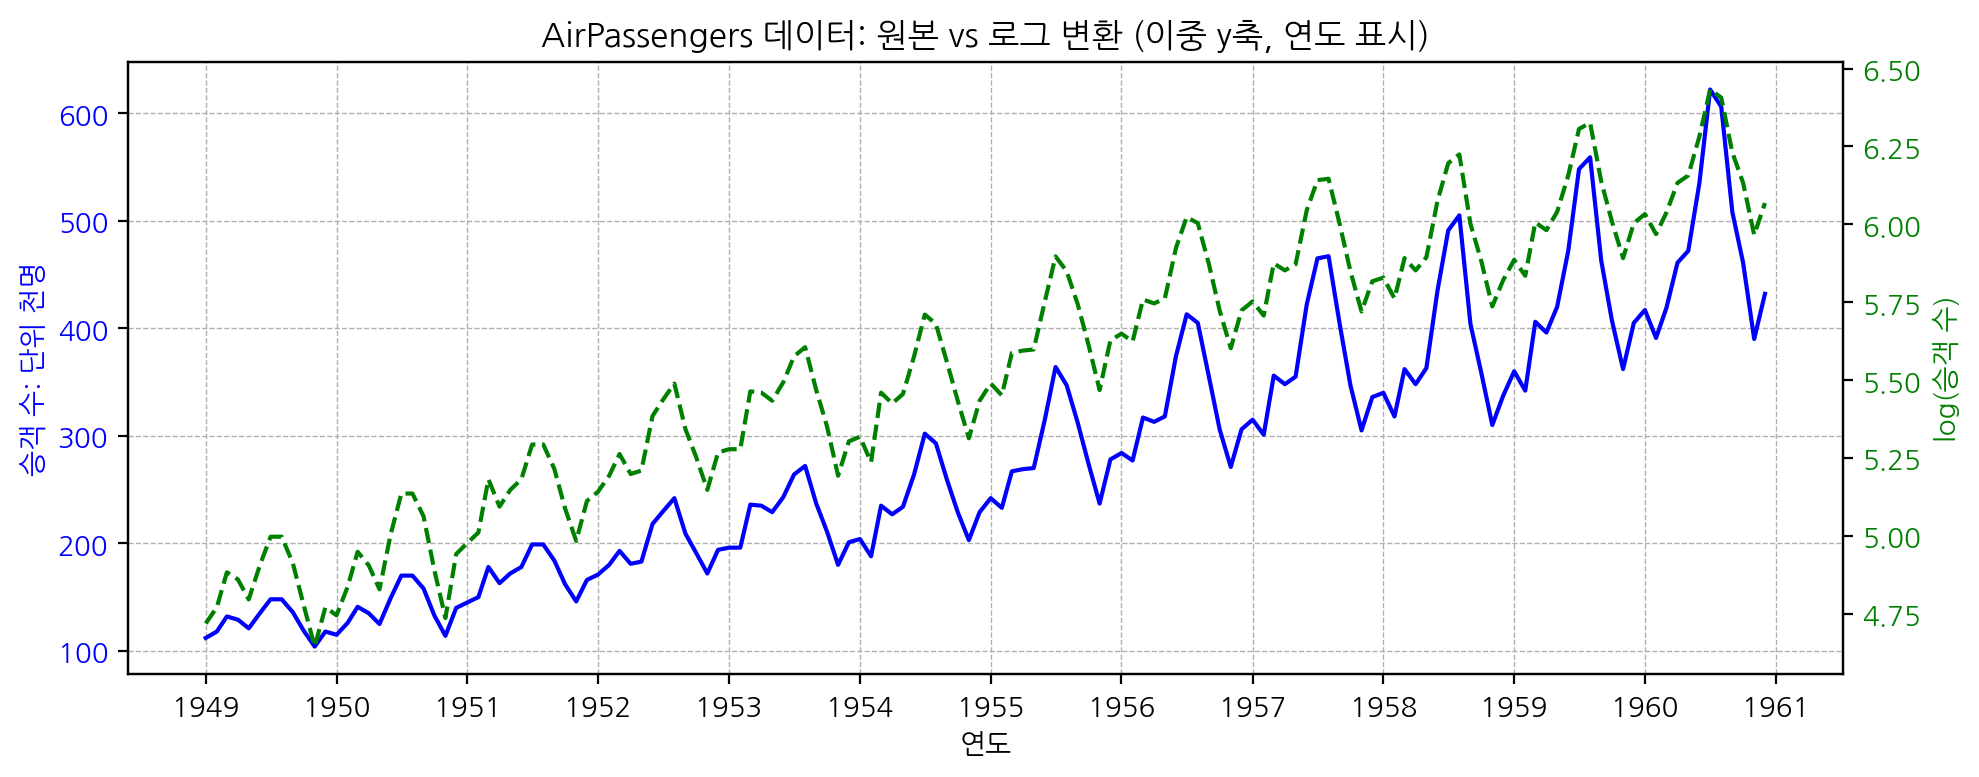

In [5]:
# Matplotlib의 날짜/시간 전용 유틸 모듈
# 축을 날짜형으로 다룰 때 축 눈금 배치(Locator)와 라벨 형식(Formatter) 지원
import matplotlib.dates as mdates

# 로그 변환
df['Passengers_log'] = np.log(df['Passengers'])

# 시각화 시작
fig, ax1 = plt.subplots(figsize=(10, 4))

# 왼쪽 y축: 원본 승객 수
ax1.set_xlabel('연도')
ax1.set_ylabel('승객 수: 단위 천명', color='blue')
ax1.plot(df.index, df['Passengers'], color='blue', label='원본 승객 수')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# 오른쪽 y축: 로그 변환 승객 수
ax2 = ax1.twinx()
ax2.set_ylabel('log(승객 수)', color='green')
ax2.plot(df.index, df['Passengers_log'], color='green', linestyle='--', label='로그 변환')
ax2.tick_params(axis='y', labelcolor='green')

# x축: 연도만 표시
# x축 눈금 간격을 1년 단위로 설정 (예: 1949, 1950, 1951, ...)
ax1.xaxis.set_major_locator(mdates.YearLocator())
# x축 눈금의 날짜 형식을 '연도(YYYY)' 형식으로 지정 (예: 1955)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 제목
plt.title("AirPassengers 데이터: 원본 vs 로그 변환 (이중 y축, 연도 표시)")
plt.tight_layout()
plt.show()

In [6]:
# 시퀀스 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X_all, y_all = create_sequences(scaled_data, SEQ_LENGTH)
# RNN 입력 규격(배치×시퀀스길이×특성수)을 강제하기 위해
# X_all = X_all.reshape(-1, SEQ_LENGTH, 1)

# 데이터 분할
n = len(X_all)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

### 2층 구조의 RNN(LSTM 또는 GRU) 모델을 생성하는 함수
- cell='LSTM’(기본값): 사용할 순환층 종류 선택 ('LSTM' 또는 'GRU')
- 첫 번째 순환층: LSTM 또는 GRU 중, 선택노드 수: 64
  - return_sequences=True: 다음 층에도 시퀀스를 넘겨주기 위해 필요
- 두 번째 순환층: 노드 수: 32
  - return_sequences=False (기본값): 코드에 없음
    - 마지막 출력만 다음 층으로 전달이 층에서 시퀀스를 요약해서 출력
    - 최종 예측으로 연결됨


In [7]:
# 2층 모델 생성 함수
def build_model(cell='LSTM', lr=0.001, use_early_stopping=True):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(SEQ_LENGTH, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True) if cell == 'LSTM' else tf.keras.layers.GRU(64, return_sequences=True),
        tf.keras.layers.LSTM(32) if cell == 'LSTM' else tf.keras.layers.GRU(32),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
    ]
    if use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1))

    return model, callbacks

### LSTM과 GRU 모델을 각각 생성하여 학습하고, 결과를 저장
- use_early_stopping=True:
  - (EarlyStopping + 학습률 스케줄링)이 함께 반환
- results[cell_type] = {...}: 각 모델의 객체와 fit() 과정의 history를 results 딕셔너리에 저장
  - 키는 'LSTM' 또는 'GRU’
  - 값은 model 객체와 fit() 결과로 반환된 history


In [8]:
# 모델 학습 및 평가
results = {}
predictions = {}
for cell_type in ['LSTM', 'GRU']:
    model, callbacks = build_model(cell=cell_type, lr=0.001, use_early_stopping=True)
    print(f'모델 {cell_type} 학습과 저장')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300, batch_size=16, verbose=0,
        callbacks=callbacks
    )
    results[cell_type] = {
        'model': model,
        'history': history,
    }

모델 LSTM 학습과 저장

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 8.
모델 GRU 학습과 저장

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 103: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 113: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 127: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 137: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 147: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 157: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 157: early stopping
Restoring model weights from the end of the best epoch: 127.


### 모델 예측
- model.predict(X_test): 테스트 데이터를 사용해 예측을 수행
- X_test는 (예: 20, 12, 1) 형태의 3D 배열
### 원래 값인 항공 승객 수로 변환
- 예측값(lstm_pred, gru_pred)은 로그 연산 후 정규화된 상태임 (0~1 범위)
- np.exp(scaler.inverse_transform(...)): 원 스케일로 복원하기 위해 exp(역정규화) 수행



In [9]:
# LSTM과 GRU 모델로 각각 예측
# 정규화된 예측 결과 저장
lstm_pred = results['LSTM']['model'].predict(X_test)
gru_pred  = results['GRU']['model'].predict(X_test)

# 역정규화 + 로그 역변환
# 실제 값 저장
lstm_pred_inv = np.exp(scaler.inverse_transform(lstm_pred))
gru_pred_inv  = np.exp(scaler.inverse_transform(gru_pred))
y_test_inv    = np.exp(scaler.inverse_transform(y_test))

# LSTM 모델
# 정량적 성능 평가 지표 저장
results['LSTM']['mse'] = mean_squared_error(y_test_inv, lstm_pred_inv)
results['LSTM']['mae'] = mean_absolute_error(y_test_inv, lstm_pred_inv)
# 예측 한 실제 값과 정답을 저장
results['LSTM']['pred_inv'] = lstm_pred_inv
results['LSTM']['true_inv'] = y_test_inv

# GRU 모델
# 정량적 성능 평가 지표 저장
results['GRU']['mse'] = mean_squared_error(y_test_inv, gru_pred_inv)
results['GRU']['mae'] = mean_absolute_error(y_test_inv, gru_pred_inv)
# 예측 한 실제 값과 정답을 저장
results['GRU']['pred_inv'] = gru_pred_inv
results['GRU']['true_inv'] = y_test_inv

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


In [10]:
# 결과 출력
for name in results:
    print(f"[{name}] MSE: {results[name]['mse']:.2f}, MAE: {results[name]['mae']:.2f}")

[LSTM] MSE: 9498.20, MAE: 72.82
[GRU] MSE: 1746.18, MAE: 32.95


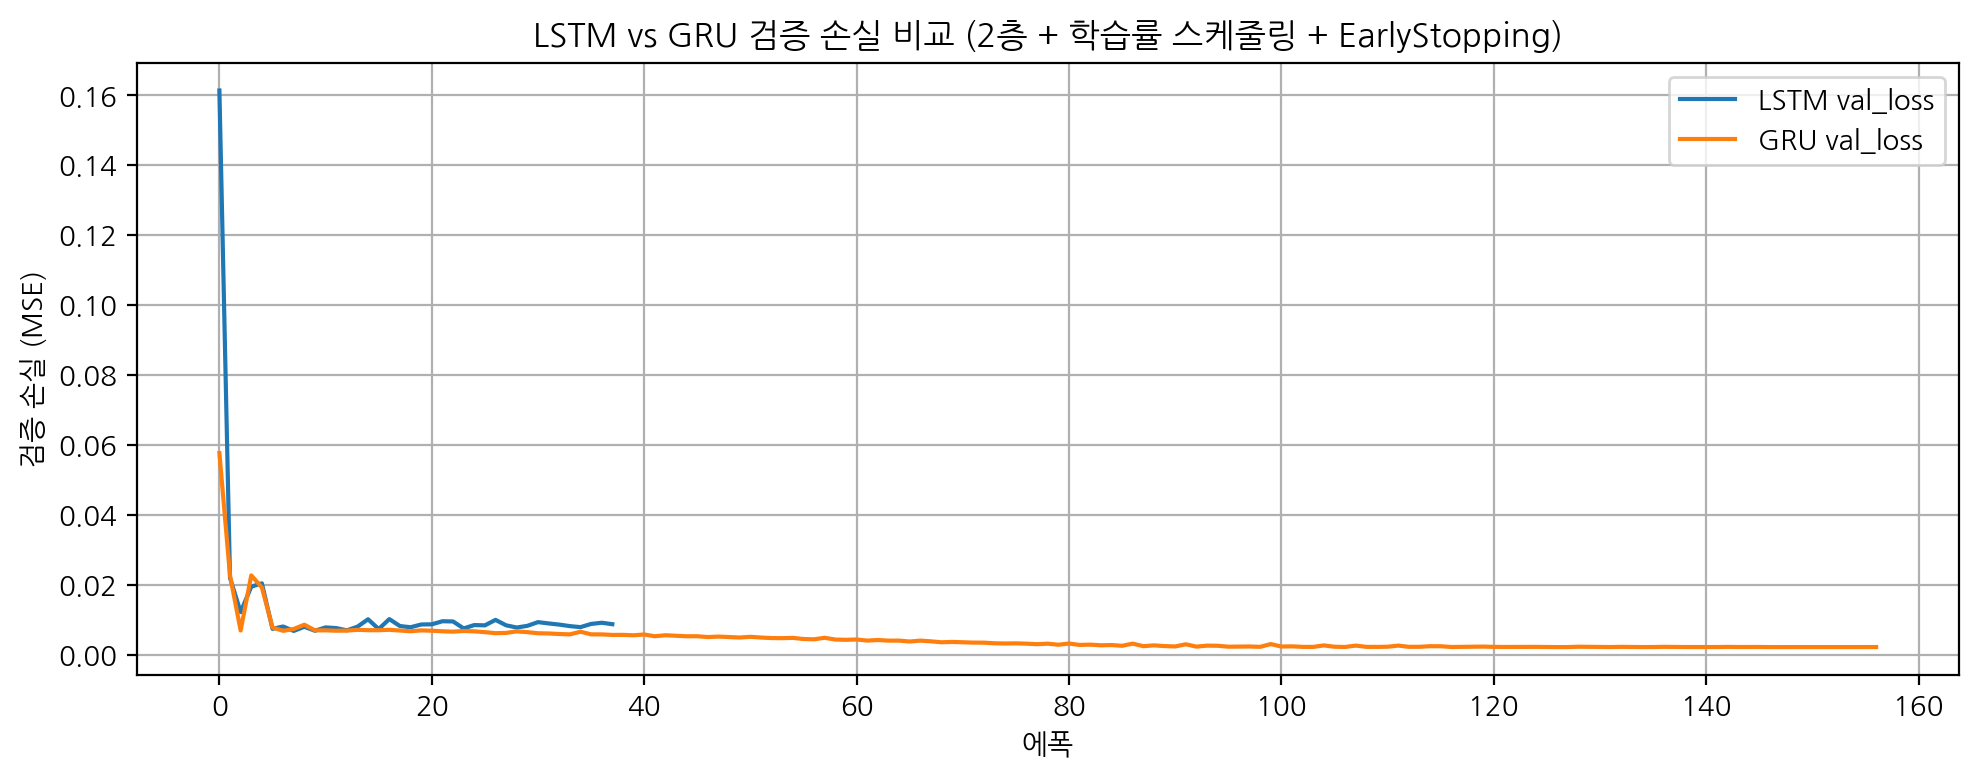

In [11]:
# 검증 손실 시각화
plt.figure(figsize=(10, 4))
for name in results:
    plt.plot(results[name]['history'].history['val_loss'], label=f'{name} val_loss')
plt.title("LSTM vs GRU 검증 손실 비교 (2층 + 학습률 스케줄링 + EarlyStopping)")
plt.xlabel("에폭")
plt.ylabel("검증 손실 (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

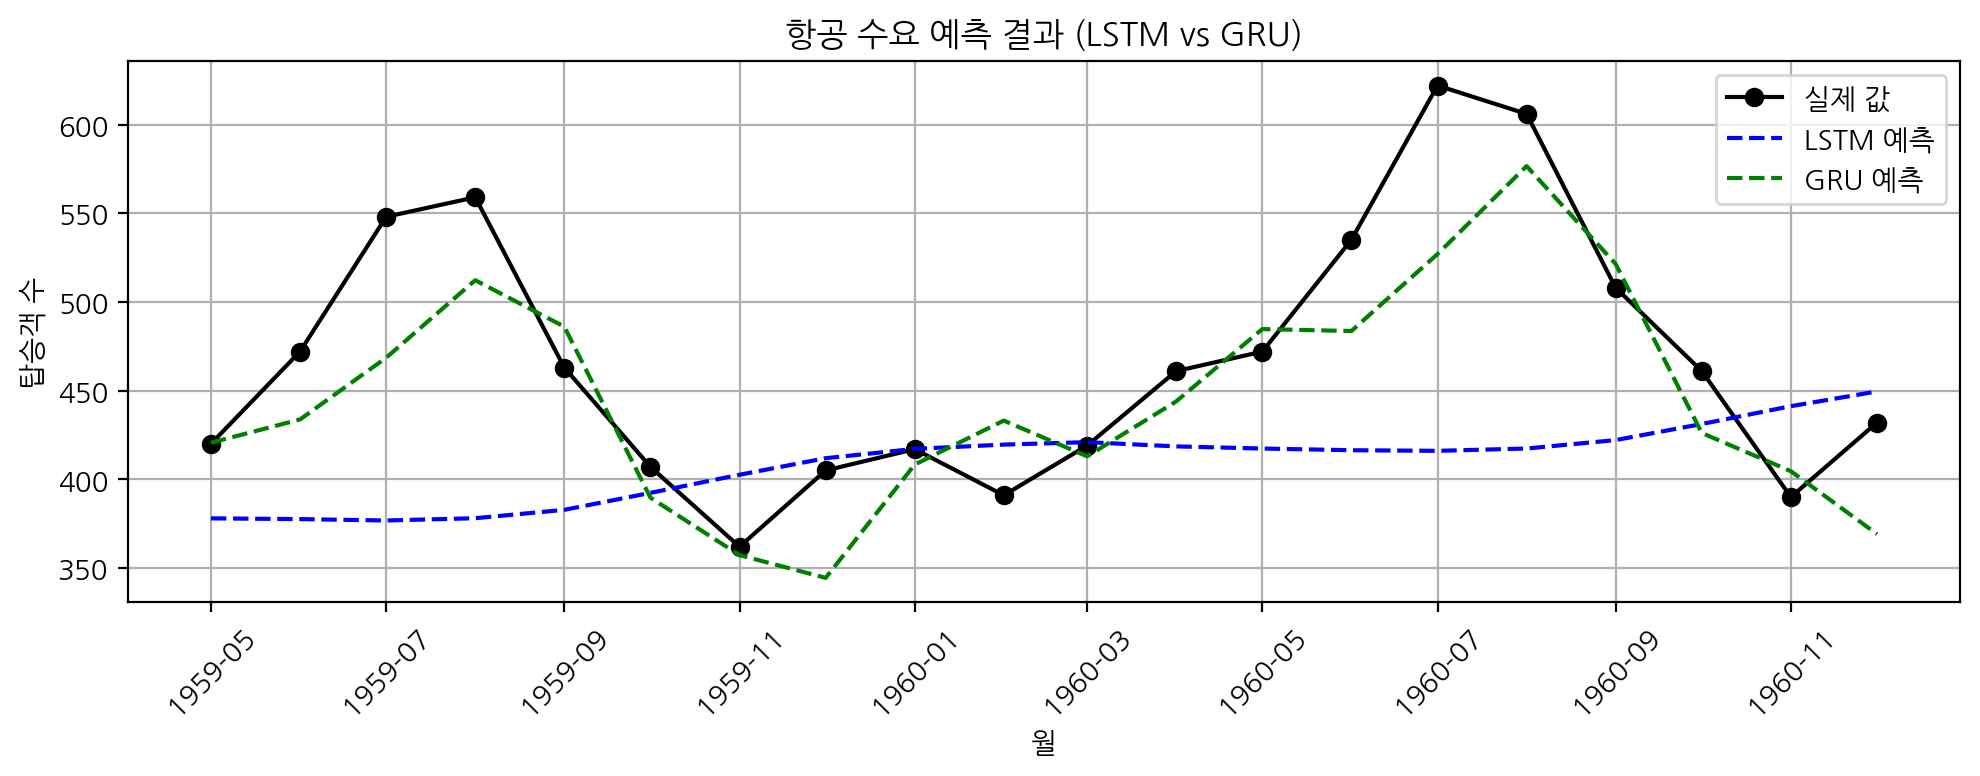

In [12]:
# 8. 예측 결과 시각화
plt.figure(figsize=(10, 4))
dates = df.index[SEQ_LENGTH + val_end : SEQ_LENGTH + val_end + len(y_test)]
plt.plot(dates, results['LSTM']['true_inv'], 'ko-', label='실제 값')
plt.plot(dates, results['LSTM']['pred_inv'], 'b--', label='LSTM 예측')
plt.plot(dates, results['GRU']['pred_inv'], 'g--', label='GRU 예측')
plt.title("항공 수요 예측 결과 (LSTM vs GRU)")
plt.xlabel("월")
plt.ylabel("탑승객 수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 전체 코드


Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
[LSTM] MSE: 9283.17, MAE: 72.34
[GRU] MSE: 8356.99, MAE: 70.85


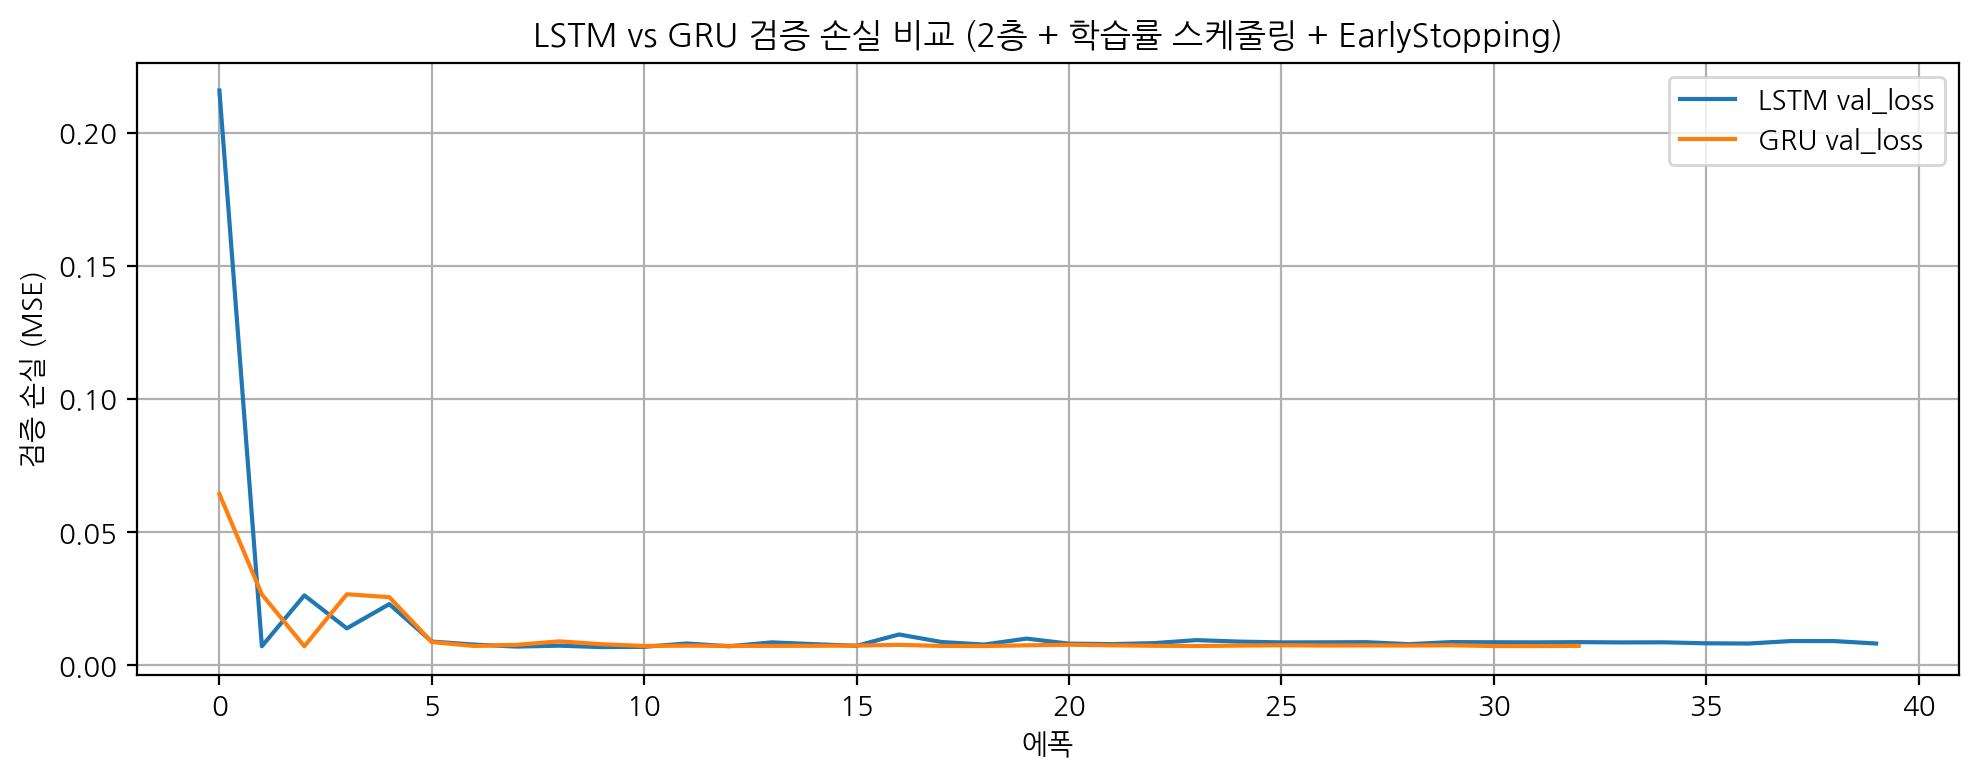

In [13]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import koreanize_matplotlib

# 1. 데이터 로드 및 전처리
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# 로그 변환 + 정규화
df['Passengers_log'] = np.log(df['Passengers'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Passengers_log']])

# 시퀀스 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X_all, y_all = create_sequences(scaled_data, SEQ_LENGTH)
X_all = X_all.reshape(-1, SEQ_LENGTH, 1)

# 데이터 분할
n = len(X_all)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

# 2층 모델 생성 함수
def build_model(cell='LSTM', lr=0.001, use_early_stopping=True):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(SEQ_LENGTH, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True) if cell == 'LSTM' else tf.keras.layers.GRU(64, return_sequences=True),
        tf.keras.layers.LSTM(32) if cell == 'LSTM' else tf.keras.layers.GRU(32),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
    ]
    if use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True))

    return model, callbacks

# 모델 학습 및 평가 (predict는 loop 밖에서 실행하여 retrace 방지)
results = {}
predictions = {}
for cell_type in ['LSTM', 'GRU']:
    model, callbacks = build_model(cell=cell_type, lr=0.001, use_early_stopping=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300, batch_size=16, verbose=0,
        callbacks=callbacks
    )
    results[cell_type] = {
        'model': model,
        'history': history,
    }

# LSTM과 GRU 모델로 각각 예측
lstm_pred = results['LSTM']['model'].predict(X_test)
gru_pred  = results['GRU']['model'].predict(X_test)

# 역정규화 + 로그 역변환
lstm_pred_inv = np.exp(scaler.inverse_transform(lstm_pred))
gru_pred_inv  = np.exp(scaler.inverse_transform(gru_pred))
y_test_inv    = np.exp(scaler.inverse_transform(y_test))

# 성능 평가 저장
results['LSTM']['mse'] = mean_squared_error(y_test_inv, lstm_pred_inv)
results['LSTM']['mae'] = mean_absolute_error(y_test_inv, lstm_pred_inv)
results['LSTM']['pred_inv'] = lstm_pred_inv
results['LSTM']['true_inv'] = y_test_inv

results['GRU']['mse'] = mean_squared_error(y_test_inv, gru_pred_inv)
results['GRU']['mae'] = mean_absolute_error(y_test_inv, gru_pred_inv)
results['GRU']['pred_inv'] = gru_pred_inv
results['GRU']['true_inv'] = y_test_inv

# 결과 출력
for name in results:
    print(f"[{name}] MSE: {results[name]['mse']:.2f}, MAE: {results[name]['mae']:.2f}")

# 검증 손실 시각화
plt.figure(figsize=(10, 4))
for name in results:
    plt.plot(results[name]['history'].history['val_loss'], label=f'{name} val_loss')
plt.title("LSTM vs GRU 검증 손실 비교 (2층 + 학습률 스케줄링 + EarlyStopping)")
plt.xlabel("에폭")
plt.ylabel("검증 손실 (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


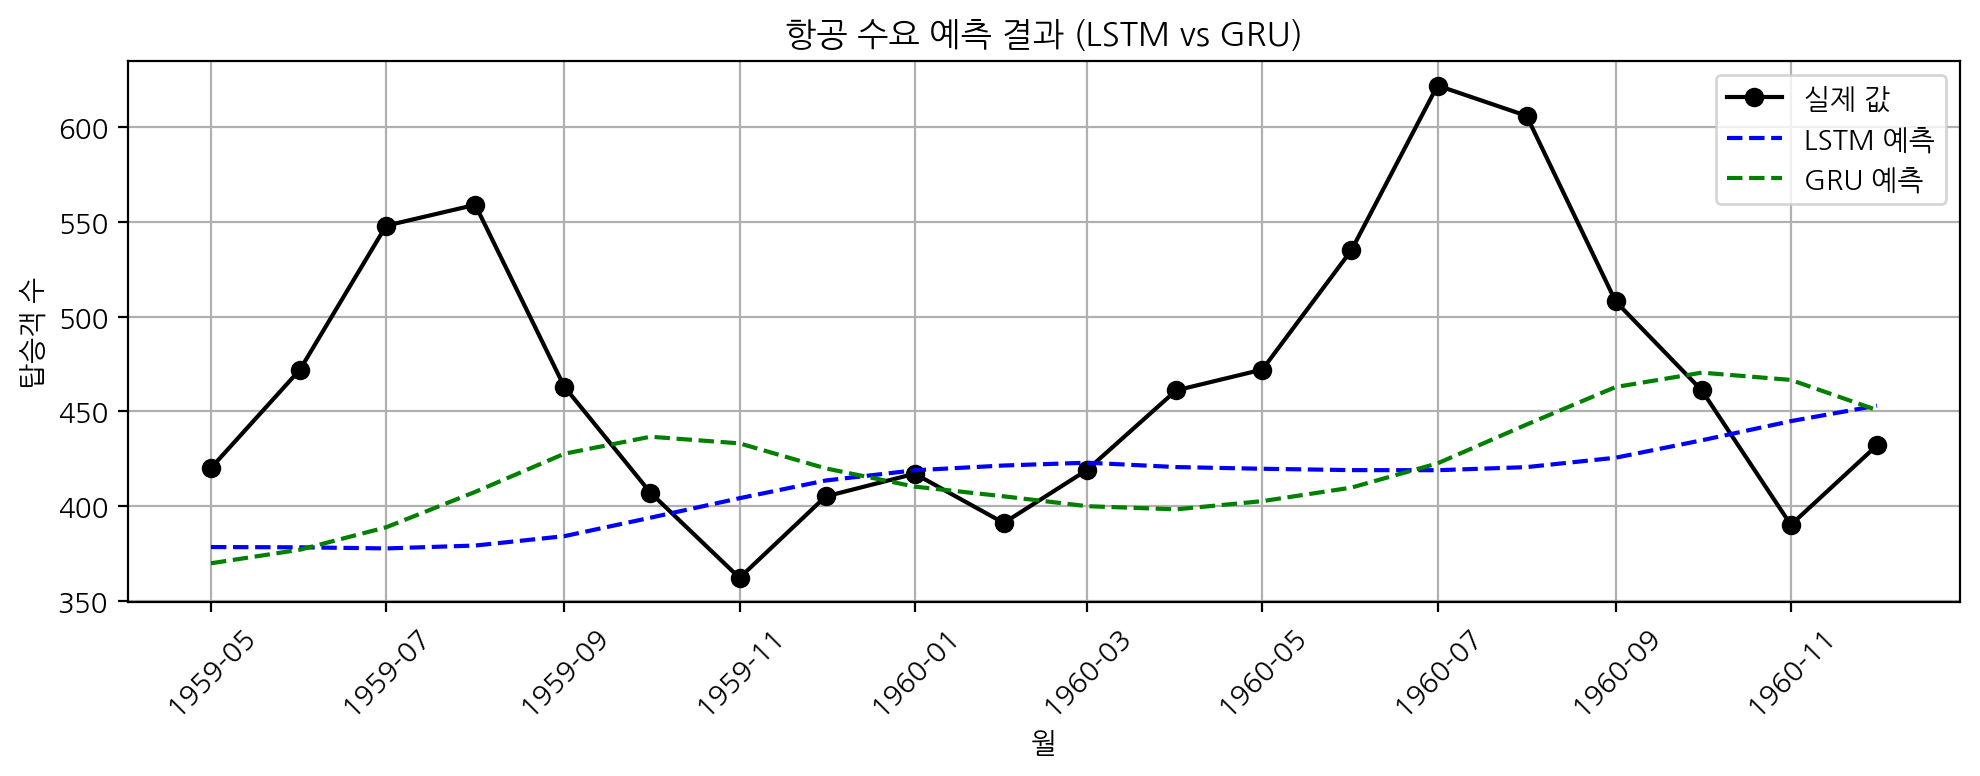

In [14]:
# 8. 예측 결과 시각화
plt.figure(figsize=(10, 4))
dates = df.index[SEQ_LENGTH + val_end : SEQ_LENGTH + val_end + len(y_test)]
plt.plot(dates, results['LSTM']['true_inv'], 'ko-', label='실제 값')
plt.plot(dates, results['LSTM']['pred_inv'], 'b--', label='LSTM 예측')
plt.plot(dates, results['GRU']['pred_inv'], 'g--', label='GRU 예측')
plt.title("항공 수요 예측 결과 (LSTM vs GRU)")
plt.xlabel("월")
plt.ylabel("탑승객 수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 모든 에폭 수행하도록 설정: use_early_stopping=False


Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 58: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 68: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 78: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 105: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 115: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 125: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
[LSTM] MSE: 5826.19, MAE: 62.20
[GRU] MSE: 1832.32, MAE: 33.98


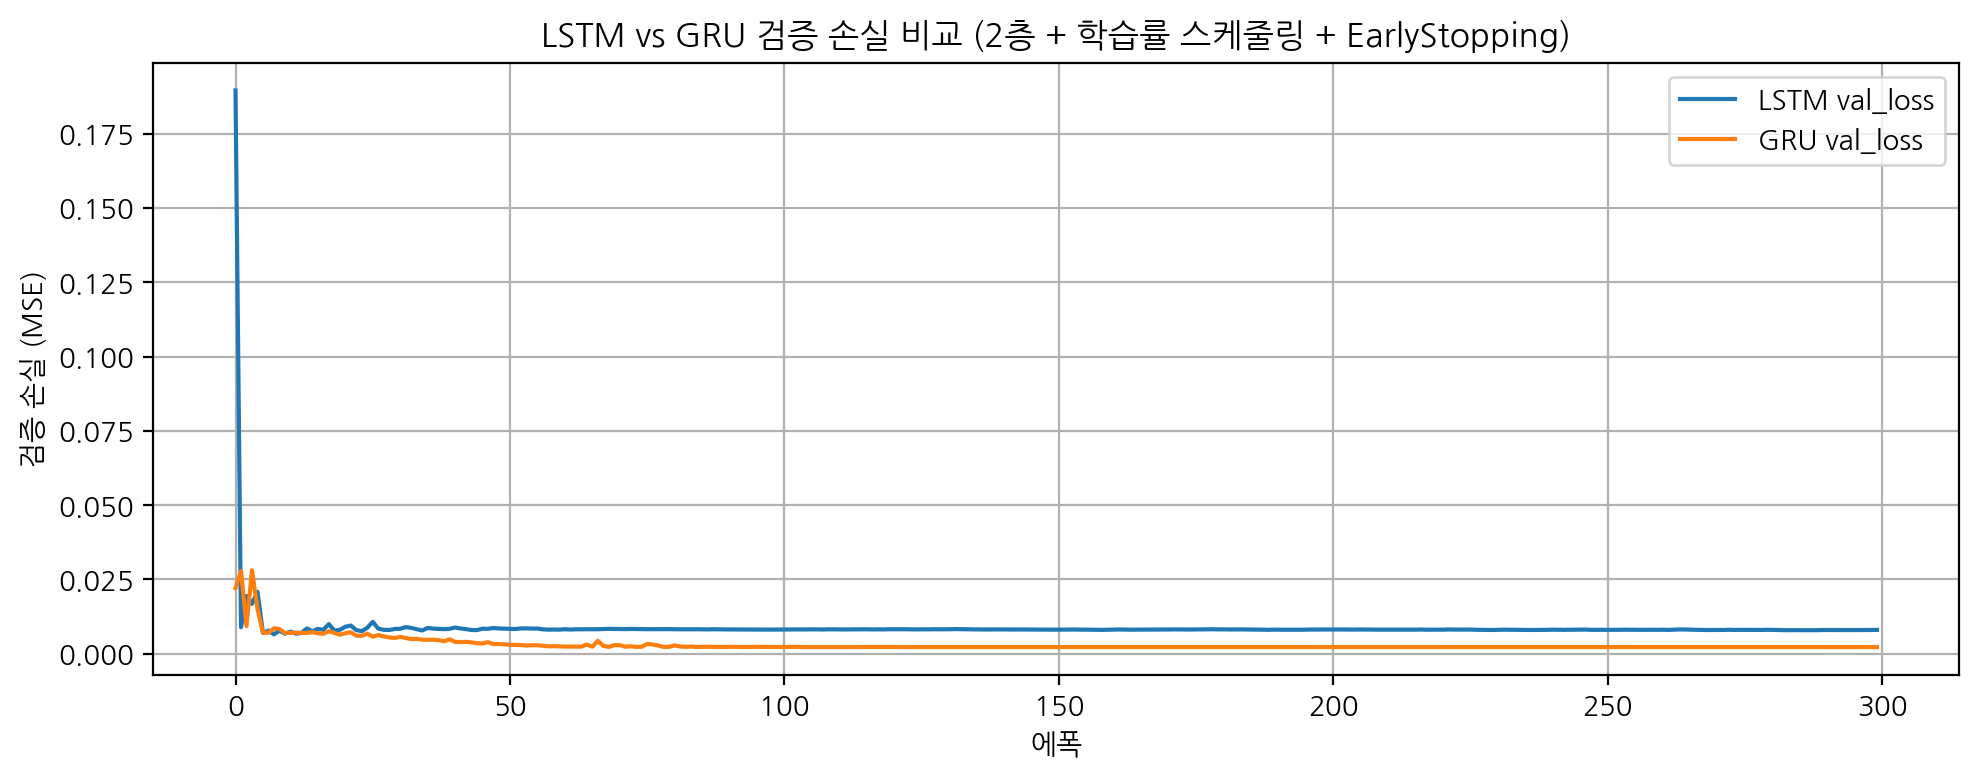

In [15]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import koreanize_matplotlib

# 1. 데이터 로드 및 전처리
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# 로그 변환 + 정규화
df['Passengers_log'] = np.log(df['Passengers'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Passengers_log']])

# 시퀀스 생성
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X_all, y_all = create_sequences(scaled_data, SEQ_LENGTH)
X_all = X_all.reshape(-1, SEQ_LENGTH, 1)

# 데이터 분할
n = len(X_all)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

# 2층 모델 생성 함수
def build_model(cell='LSTM', lr=0.001, use_early_stopping=True):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(SEQ_LENGTH, 1)),
        tf.keras.layers.LSTM(64, return_sequences=True) if cell == 'LSTM' else tf.keras.layers.GRU(64, return_sequences=True),
        tf.keras.layers.LSTM(32) if cell == 'LSTM' else tf.keras.layers.GRU(32),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5, verbose=1)
    ]
    if use_early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True))

    return model, callbacks

# 모델 학습 및 평가 (predict는 loop 밖에서 실행하여 retrace 방지)
results = {}
predictions = {}
for cell_type in ['LSTM', 'GRU']:
    model, callbacks = build_model(cell=cell_type, lr=0.001, use_early_stopping=False)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300, batch_size=16, verbose=0,
        callbacks=callbacks
    )
    results[cell_type] = {
        'model': model,
        'history': history,
    }

# LSTM과 GRU 모델로 각각 예측
lstm_pred = results['LSTM']['model'].predict(X_test)
gru_pred  = results['GRU']['model'].predict(X_test)

# 역정규화 + 로그 역변환
lstm_pred_inv = np.exp(scaler.inverse_transform(lstm_pred))
gru_pred_inv  = np.exp(scaler.inverse_transform(gru_pred))
y_test_inv    = np.exp(scaler.inverse_transform(y_test))

# 성능 평가 저장
results['LSTM']['mse'] = mean_squared_error(y_test_inv, lstm_pred_inv)
results['LSTM']['mae'] = mean_absolute_error(y_test_inv, lstm_pred_inv)
results['LSTM']['pred_inv'] = lstm_pred_inv
results['LSTM']['true_inv'] = y_test_inv

results['GRU']['mse'] = mean_squared_error(y_test_inv, gru_pred_inv)
results['GRU']['mae'] = mean_absolute_error(y_test_inv, gru_pred_inv)
results['GRU']['pred_inv'] = gru_pred_inv
results['GRU']['true_inv'] = y_test_inv

# 결과 출력
for name in results:
    print(f"[{name}] MSE: {results[name]['mse']:.2f}, MAE: {results[name]['mae']:.2f}")

# 검증 손실 시각화
plt.figure(figsize=(10, 4))
for name in results:
    plt.plot(results[name]['history'].history['val_loss'], label=f'{name} val_loss')
plt.title("LSTM vs GRU 검증 손실 비교 (2층 + 학습률 스케줄링 + EarlyStopping)")
plt.xlabel("에폭")
plt.ylabel("검증 손실 (MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


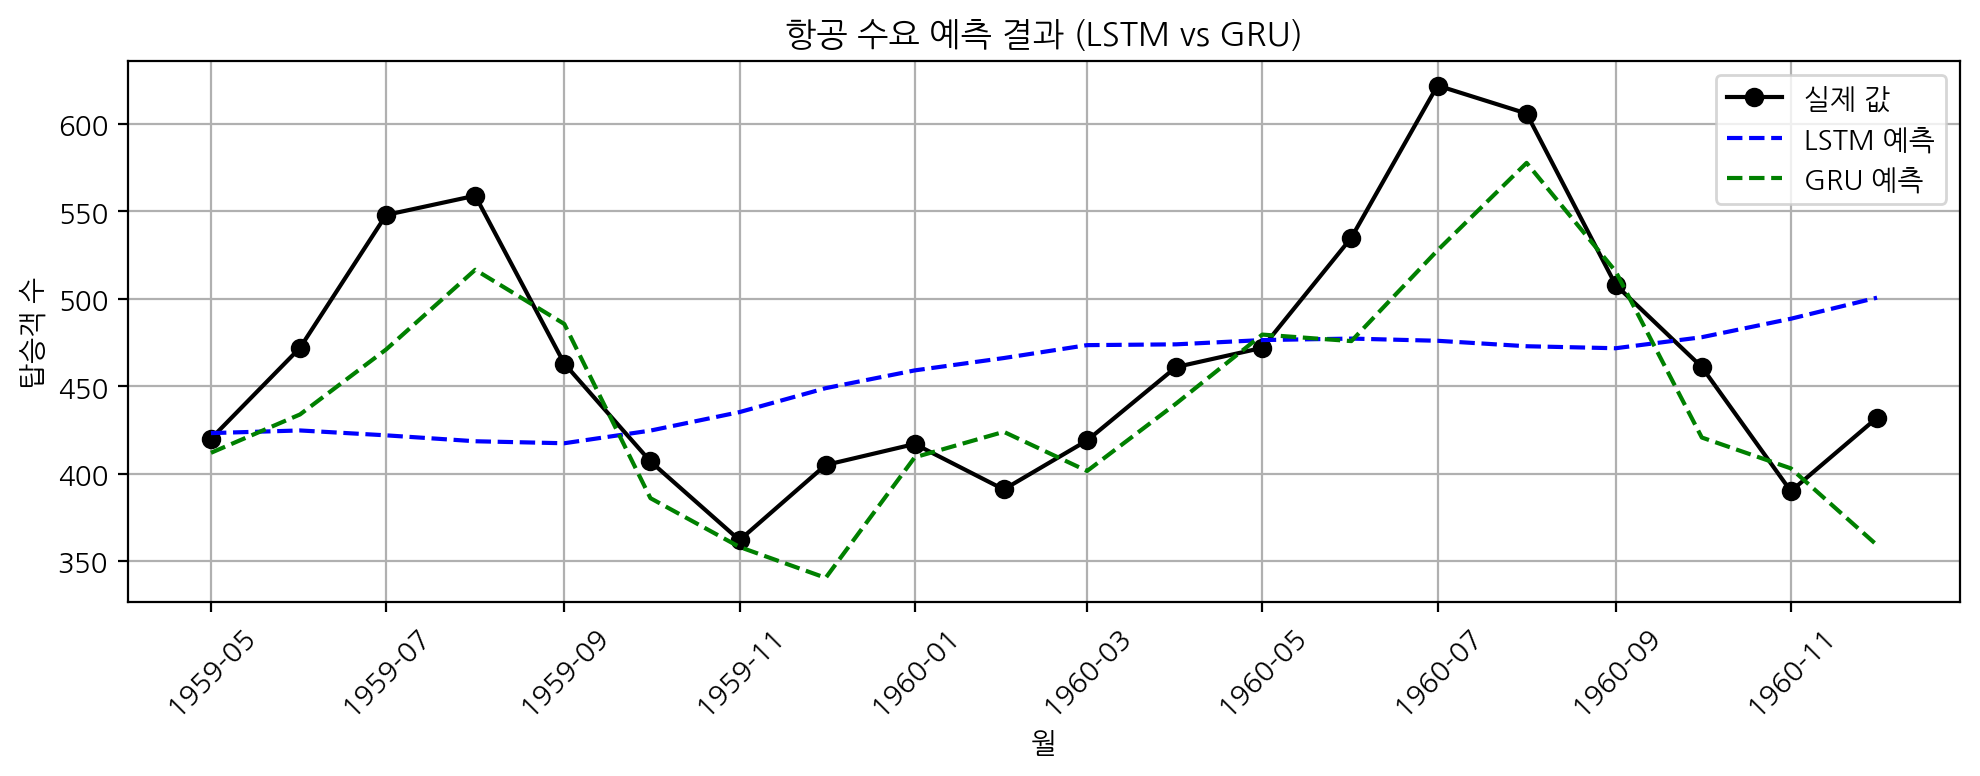

In [16]:
# 8. 예측 결과 시각화
plt.figure(figsize=(10, 4))
dates = df.index[SEQ_LENGTH + val_end : SEQ_LENGTH + val_end + len(y_test)]
plt.plot(dates, results['LSTM']['true_inv'], 'ko-', label='실제 값')
plt.plot(dates, results['LSTM']['pred_inv'], 'b--', label='LSTM 예측')
plt.plot(dates, results['GRU']['pred_inv'], 'g--', label='GRU 예측')
plt.title("항공 수요 예측 결과 (LSTM vs GRU)")
plt.xlabel("월")
plt.ylabel("탑승객 수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 종료